In [281]:
import netCDF4 as nc
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import pyproj as proj
import scipy.stats as stats
sys.path.append("../")
from src import visualization as vis

In [2]:
def get_data(species):
    data_base = pd.read_csv("../data/model_sims/baseline/{}/settled_data.csv".format(species))
    data_base = data_base.drop(columns=["Unnamed: 0"])
    data_base = data_base.dropna()

    data_warm = pd.read_csv("../data/model_sims/warm/{}/settled_data.csv".format(species))
    data_warm = data_warm.drop(columns=["Unnamed: 0"])
    data_warm = data_warm.dropna()
    
    return data_base, data_warm

In [3]:
def get_settled(data):
    return data[data['settled_particles'] == 1.0]

def project(x, y, to_lola=False):
    proj_out = proj.Proj('esri:102284')

    xproj, yproj = proj_out(x, y, inverse=to_lola)

    return xproj, yproj

In [201]:
def distance(xs1, xs2, ys1, ys2):
    xs_diff = np.abs(np.subtract(xs2, xs1))
    ys_diff = np.abs(np.subtract(ys2, ys1))
    return np.sqrt(np.square(xs_diff)+np.square(ys_diff))

def compute_dispersal_kernel(start_xs, end_xs, start_ys, end_ys, nbins=range(0, 1010, 10), std=True):
    dis = distance(start_xs, end_xs, start_ys, end_ys)
    dis = dis/1000

    mean = np.mean(dis)
    median = np.median(dis)
    
    hist, bins = np.histogram(dis, bins=nbins)
    
    if std:
        hist = hist/hist.sum()
        
    return hist, bins, mean, median

In [284]:
def compute_annual_kernel(d, y):
    data = d[d.years == y]
    base_start_xs, base_start_ys = project(data['init_lons'].to_numpy(), data['init_lats'].to_numpy())
    base_final_xs, base_final_ys = project(data['final_lons'].to_numpy(), data['final_lats'].to_numpy())
    data_base

    h, bins, mean, median = compute_dispersal_kernel(base_start_xs, base_final_xs, base_start_ys, base_final_ys)
    return h, bins, mean, median

def average_kernels_annual(data, years):
    hists = np.zeros(shape=(5, 100))
    means = np.zeros(shape=(5,))
    medians = np.zeros(shape=(5,))
    for i, y in enumerate(years):
        h, bins, mean, median = compute_annual_kernel(data, y)
        hists[i] = h
        means[i] = mean
        medians[i] = median

    return hists.mean(axis=0), hists.std(axis=0), means.mean(), means.std(), medians.mean(), medians.std(), bins, hists

def ttest(hists_base, hists_warm):
    ttest = stats.ttest_ind(hists_warm, hists_base)
    pvals = ttest.pvalue
    sig_idx = np.where(pvals < 0.05)[0]
    sig_dis = sig_idx*10
    return sig_dis, sig_idx, pvals
    
    

In [63]:
def plot_dispersal_kernel(hists, bins, means, medians, title, ylims=(0, 0.05), ax=None):

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    
    ax, bars = vis.plot_dispersal_kernel(hists[0], bins[0], ax=ax, color="blue", alpha=0.5, label="Baseline Time Period")
    ax, bars = vis.plot_dispersal_kernel(hists[1], bins[1], ax=ax, color="red", alpha=0.5, label="Warm Time Period")

    ax.vlines(means[0], ylims[0], ylims[1], linestyles="dashed", colors="blue", label="Baseline Mean")
    ax.vlines(medians[0], ylims[0], ylims[1], linestyles="dotted", colors="blue", label="Baseline Median")
    ax.vlines(means[1], ylims[0], ylims[1], linestyles="dashed", colors="red", label="Warm Mean")
    ax.vlines(medians[1], ylims[0], ylims[1], linestyles="dotted", colors="red", label="Warm Median")

    handles,labels = ax.get_legend_handles_labels()
    order=[4, 0, 1, 5, 2, 3]

    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

    ax.set_xlabel("Distance Traveled (km)")
    ax.set_ylabel("Proportion of Particles")

    ax.set_title(title)

    ax.set_ylim(ylims)
    ax.set_xlim((0, 1000))
    ax.set_xticks(range(0, 1100, 100))
    
    return ax

# Atlantic Cod

In [317]:
data_base, data_warm = get_data("atlantic-cod")
data_base = get_settled(data_base)
data_warm = get_settled(data_warm)

In [318]:
base_start_xs, base_start_ys = project(data_base['init_lons'].to_numpy(), data_base['init_lats'].to_numpy())
base_final_xs, base_final_ys = project(data_base['final_lons'].to_numpy(), data_base['final_lats'].to_numpy())

In [319]:
warm_start_xs, warm_start_ys = project(data_warm['init_lons'].to_numpy(), data_warm['init_lats'].to_numpy())
warm_final_xs, warm_final_ys = project(data_warm['final_lons'].to_numpy(), data_warm['final_lats'].to_numpy())

In [320]:
hmean_base, hsd_base, mean_base, _, median_base, _, bins, hists_base = average_kernels_annual(data_base, range(1984, 1989))
hmean_warm, hsd_warm, mean_warm, _, median_warm, _, bins, hists_warm = average_kernels_annual(data_warm, range(2012, 2017))

In [321]:
mean_base, mean_warm, median_base, median_warm

(100.01009086588438, 116.04984035763292, 87.09329595915014, 79.24819529479154)

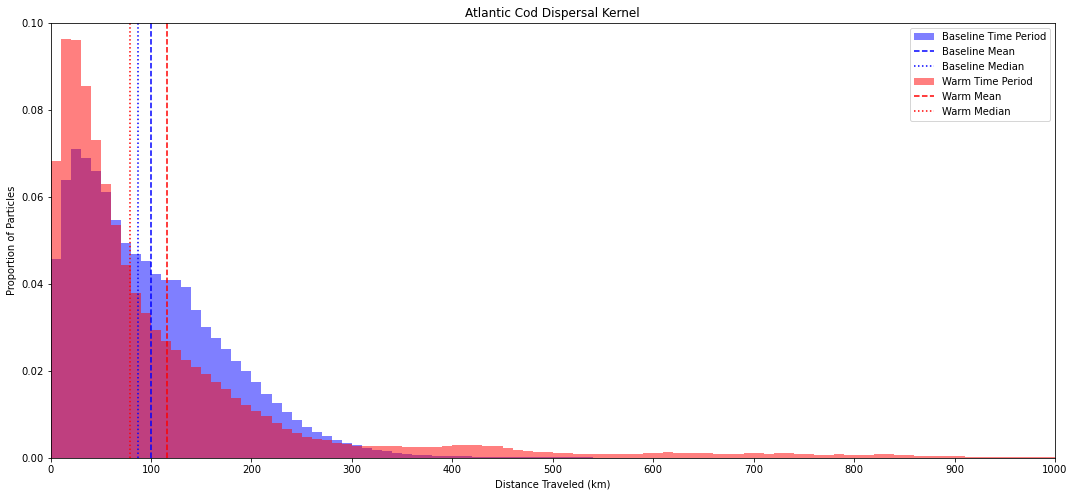

In [324]:
ax = plot_dispersal_kernel([hmean_base, hmean_warm], [bins, bins], [mean_base, mean_warm], [median_base, median_warm], title="Atlantic Cod Dispersal Kernel", ylims=(0, 0.10))
#ax, bars = vis.plot_dispersal_kernel(hist_diff, bins_warm, ax=ax, color="green", alpha=0.5, label="Baseline Time Period")

**Figure 1 - Atlantic Cod Dispersal Kernel** - Cod traveled roughly equal distances, on average, during their pelagic larval phase in both time periods (baseline: ~100.01 km; warm: ~116.05 km). Cod larvae were more likely to settle 0-100km from their spawned location under warm conditions, and 100-300km under baseline conditions. Cod larvae were aso much more likely to travel extreme distances from their settled position, as evidenced by the long tail of the warm period distribution. The number of larvae in each distance bin was significantly different only for 120-150km (0.031 < p < 0.048).

In [325]:
sig_dis, sig_idx, pvals = ttest(hists_base, hists_warm)
sig_dis, pvals[sig_idx]

(array([120, 130, 140]), array([0.03826961, 0.03060959, 0.04758524]))

In [41]:
hstd_base, _, _, _ = compute_dispersal_kernel(base_start_xs, base_final_xs, base_start_ys, base_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
hstd_warm, _, _, _ = compute_dispersal_kernel(warm_start_xs, warm_final_xs, warm_start_ys, warm_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

hstd_warm, hstd_base, (hstd_warm - hstd_base)

(array([0.66790829, 0.20565382, 0.06036717, 0.02194269, 0.01680736,
        0.00714942, 0.00787741, 0.00628696, 0.00440229, 0.0016046 ]),
 array([5.51473857e-01, 3.31739299e-01, 9.92578480e-02, 1.43377618e-02,
        2.31839405e-03, 6.72438749e-04, 1.21570847e-04, 6.45845126e-05,
        1.23470392e-05, 1.89954449e-06]),
 array([ 0.11643443, -0.12608548, -0.03889068,  0.00760493,  0.01448897,
         0.00647698,  0.00775584,  0.00622238,  0.00438994,  0.0016027 ]))

# Haddock

In [326]:
data_base, data_warm = get_data("haddock")
data_base = get_settled(data_base)
data_warm = get_settled(data_warm)

In [327]:
base_start_xs, base_start_ys = project(data_base['init_lons'].to_numpy(), data_base['init_lats'].to_numpy())
base_final_xs, base_final_ys = project(data_base['final_lons'].to_numpy(), data_base['final_lats'].to_numpy())

In [328]:
warm_start_xs, warm_start_ys = project(data_warm['init_lons'].to_numpy(), data_warm['init_lats'].to_numpy())
warm_final_xs, warm_final_ys = project(data_warm['final_lons'].to_numpy(), data_warm['final_lats'].to_numpy())

In [329]:
hmean_base, hsd_base, mean_base, _, median_base, _, bins, hists_base = average_kernels_annual(data_base, range(1984, 1989))
hmean_warm, hsd_warm, mean_warm, _, median_warm, _, bins, hists_warm = average_kernels_annual(data_warm, range(2012, 2017))

In [330]:
mean_base, mean_warm, median_base, median_warm

(160.6150867284681, 171.41327067631187, 135.15172154565636, 143.40155722591194)

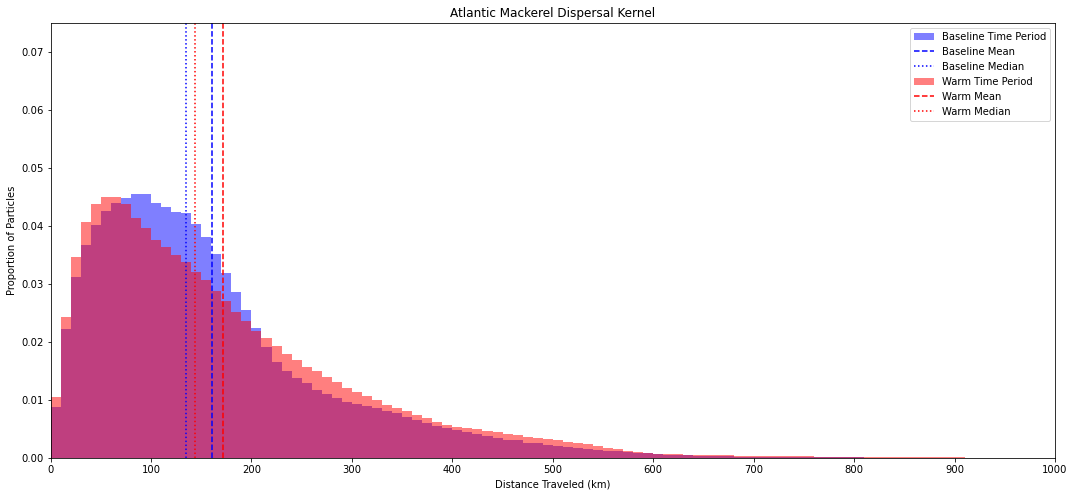

In [297]:
ax = plot_dispersal_kernel([hmean_base, hmean_warm], [bins, bins], [mean_base, mean_warm], [median_base, median_warm], title="Haddock Dispersal Kernel", ylims=(0, 0.075))
#ax, bars = vis.plot_dispersal_kernel(hist_diff, bins_warm, ax=ax, color="green", alpha=0.5, label="Baseline Time Period")

Figure 2 - Haddock Dispersal Kernel - Haddock larvae traveled approximately equal distances, on average, in both time periods (baseline: ~160.61 km; warm: ~171.41 km). Haddock were more likely to settle 100-200km from their spawned location under baseline conditions, and warm conditions promoted slightly larger extreme travel distances. The number of larvae in each distance bin was significantly different only for 870-880km (p-value: 0.049).

In [331]:
sig_dis, sig_idx, pvals = ttest(hists_base, hists_warm)
sig_dis, pvals[sig_idx]

(array([870]), array([0.04876853]))

In [77]:
hstd_base, _, _, _ = compute_dispersal_kernel(base_start_xs, base_final_xs, base_start_ys, base_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
hstd_warm, _, _, _ = compute_dispersal_kernel(warm_start_xs, warm_final_xs, warm_start_ys, warm_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

hstd_warm, hstd_base, (hstd_warm - hstd_base)

(array([3.66804466e-01, 3.09768144e-01, 1.66382919e-01, 8.41735349e-02,
        4.39697023e-02, 1.96226591e-02, 5.07474916e-03, 2.65601084e-03,
        1.22461447e-03, 3.23200651e-04]),
 array([3.64004471e-01, 3.69776092e-01, 1.41068604e-01, 7.22014838e-02,
        3.43306919e-02, 1.33288422e-02, 3.57933336e-03, 1.10284232e-03,
        3.99989665e-04, 2.07650137e-04]),
 array([ 0.0028    , -0.06000795,  0.02531432,  0.01197205,  0.00963901,
         0.00629382,  0.00149542,  0.00155317,  0.00082462,  0.00011555]))

# Yellowtail Flounder

In [332]:
data_base, data_warm = get_data("yellowtail-flounder")
data_base = get_settled(data_base)
data_warm = get_settled(data_warm)

In [333]:
base_start_xs, base_start_ys = project(data_base['init_lons'].to_numpy(), data_base['init_lats'].to_numpy())
base_final_xs, base_final_ys = project(data_base['final_lons'].to_numpy(), data_base['final_lats'].to_numpy())

In [334]:
warm_start_xs, warm_start_ys = project(data_warm['init_lons'].to_numpy(), data_warm['init_lats'].to_numpy())
warm_final_xs, warm_final_ys = project(data_warm['final_lons'].to_numpy(), data_warm['final_lats'].to_numpy())

In [335]:
hmean_base, hsd_base, mean_base, _, median_base, _, bins, hists_base = average_kernels_annual(data_base, range(1984, 1989))
hmean_warm, hsd_warm, mean_warm, _, median_warm, _, bins, hists_warm = average_kernels_annual(data_warm, range(2012, 2017))

In [336]:
mean_base, mean_warm, median_base, median_warm

(232.43350591987692,
 235.20212842437536,
 163.03228465421506,
 186.64957419360948)

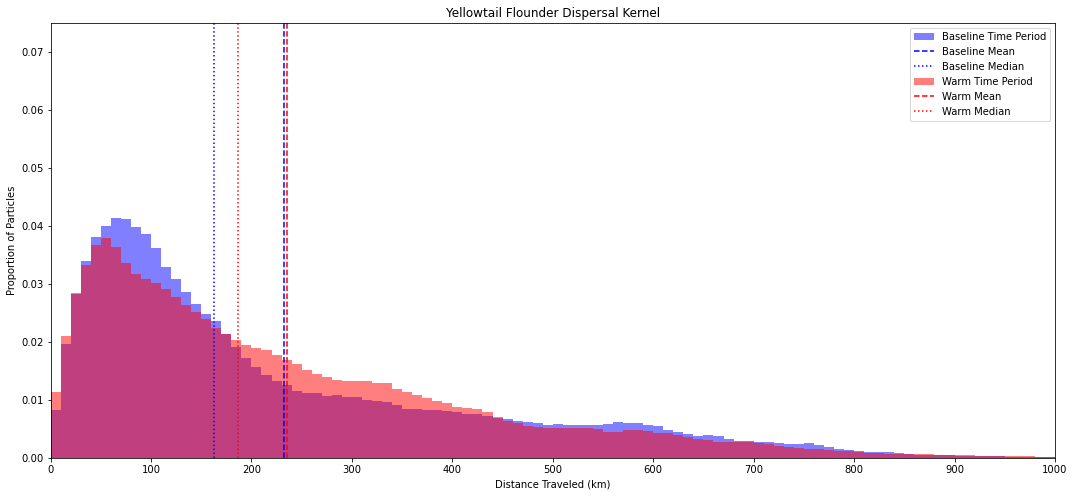

In [337]:
ax = plot_dispersal_kernel([hmean_base, hmean_warm], [bins, bins], [mean_base, mean_warm], [median_base, median_warm], title="Yellowtail Flounder Dispersal Kernel", ylims=(0, 0.075))
#ax, bars = vis.plot_dispersal_kernel(hist_diff, bins_warm, ax=ax, color="green", alpha=0.5, label="Baseline Time Period")

Figure 3 - Yellowtail Flounder Dispersal Kernel - Yellowtail flounder larvae traveled, on average, the same distance in both time periods (baseline: ~232.43km; warm: ~235.20km), and possessed similarly sized tails. In the warm period, yellowtail flounder larvae were more likely to settle 200-400km from their spawned position,while in the baseline period, larvae were slightly more likely to settle 0-200km and 500-800km from their spawned position. The number of larvae in each distance bin was significantly different only for 230-270km (0.022 < p < 0.043).

In [339]:
sig_dis, sig_idx, pvals = ttest(hists_base, hists_warm)
sig_dis, pvals[sig_idx]

(array([230, 240, 250, 260]),
 array([0.03965555, 0.02303586, 0.02285484, 0.04302871]))

In [55]:
hstd_base, _, _, _ = compute_dispersal_kernel(base_start_xs, base_final_xs, base_start_ys, base_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
hstd_warm, _, _, _ = compute_dispersal_kernel(warm_start_xs, warm_final_xs, warm_start_ys, warm_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

hstd_warm, hstd_base, (hstd_warm - hstd_base)

(array([0.30600154, 0.24742363, 0.1583718 , 0.11693483, 0.07016672,
        0.04708234, 0.02976892, 0.01518279, 0.00620269, 0.00286473]),
 array([0.32740489, 0.26131373, 0.12138017, 0.09098052, 0.06769538,
        0.05935213, 0.03990882, 0.02221916, 0.00743526, 0.00230995]),
 array([-0.02140335, -0.0138901 ,  0.03699163,  0.02595431,  0.00247134,
        -0.01226979, -0.0101399 , -0.00703636, -0.00123257,  0.00055477]))

# Atlantic Mackerel

In [340]:
data_base, data_warm = get_data("atlantic-mackerel")
data_base = get_settled(data_base)
data_warm = get_settled(data_warm)

In [341]:
base_start_xs, base_start_ys = project(data_base['init_lons'].to_numpy(), data_base['init_lats'].to_numpy())
base_final_xs, base_final_ys = project(data_base['final_lons'].to_numpy(), data_base['final_lats'].to_numpy())

In [342]:
warm_start_xs, warm_start_ys = project(data_warm['init_lons'].to_numpy(), data_warm['init_lats'].to_numpy())
warm_final_xs, warm_final_ys = project(data_warm['final_lons'].to_numpy(), data_warm['final_lats'].to_numpy())

In [343]:
hmean_base, hsd_base, mean_base, _, median_base, _, bins, hists_base = average_kernels_annual(data_base, range(1984, 1989))
hmean_warm, hsd_warm, mean_warm, _, median_warm, _, bins, hists_warm = average_kernels_annual(data_warm, range(2012, 2017))

In [344]:
mean_base, mean_warm, median_base, median_warm

(186.4866684876277, 187.0487970352877, 140.16693806932466, 166.2068365226095)

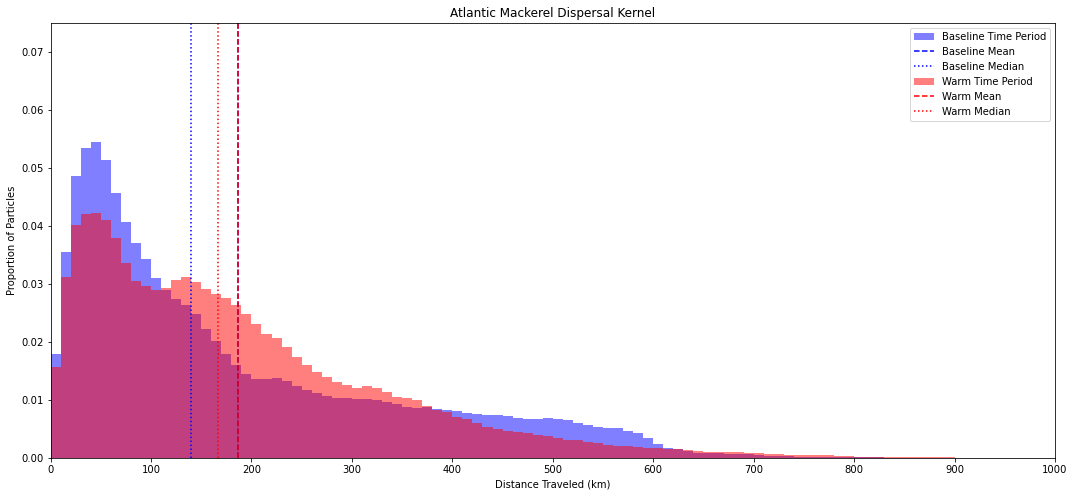

In [345]:
ax = plot_dispersal_kernel([hmean_base, hmean_warm], [bins, bins], [mean_base, mean_warm], [median_base, median_warm], title="Atlantic Mackerel Dispersal Kernel", ylims=(0, 0.075))
#ax, bars = vis.plot_dispersal_kernel(hist_diff, bins_warm, ax=ax, color="green", alpha=0.5, label="Baseline Time Period")

Figure 4 - Atlantic Mackerel Dispersal Kernel - Atlantic mackerel larvae traveled, on average, the same distance from their spawned locations in both time period (baseline: ~186.49km; warm: ~187.05km). Mackerel larvae in the warm period were much more likely to settle 100-400km from their spawned location, while mackerel larvae in the baseline time period were slightly more likely to settle 0-100km and 400-600km from their spanwed location. Mackerel larvae exhibited similar extreme dispersal distances in both time periods. The number of larvae in each distance bin was significantly different for 180-230km (0.0088 < p < 0.048) and 880-980km (0.0096 < p < 0.048).

In [346]:
sig_dis, sig_idx, pvals = ttest(hists_base, hists_warm)
sig_dis, pvals[sig_idx]

(array([180, 190, 200, 210, 220, 880, 890, 900, 910, 920, 930, 940, 950,
        960, 970]),
 array([0.03446868, 0.01200205, 0.00257497, 0.00883754, 0.0479254 ,
        0.01192747, 0.04428818, 0.01008517, 0.01969352, 0.04835977,
        0.02278478, 0.04646789, 0.02168006, 0.00956589, 0.01549984]))

In [158]:
hstd_base, _, _, _ = compute_dispersal_kernel(base_start_xs, base_final_xs, base_start_ys, base_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
hstd_warm, _, _, _ = compute_dispersal_kernel(warm_start_xs, warm_final_xs, warm_start_ys, warm_final_ys, nbins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

hstd_warm, hstd_base, (hstd_warm - hstd_base)

(array([0.33763338, 0.28486948, 0.17378749, 0.10647675, 0.05257397,
        0.02548575, 0.01236097, 0.00520702, 0.00121581, 0.00038939]),
 array([4.17903240e-01, 2.25396139e-01, 1.21006527e-01, 9.28092396e-02,
        7.39963594e-02, 5.44098494e-02, 1.14949682e-02, 2.44445242e-03,
        4.72900013e-04, 6.63241132e-05]),
 array([-0.08026987,  0.05947334,  0.05278096,  0.01366751, -0.02142239,
        -0.0289241 ,  0.00086601,  0.00276257,  0.00074291,  0.00032306]))